## Feature Engineering & Selection for UF6 Neural Network
This notebook will explore the value of feature engineering and selection for the UF6 GADRAS data set.
We will explore the predictor correlations, down-select predictors based on correlation, cross-validate to choose model hyperparameters and finally train models.

In [226]:
# import all of the libraries 

import pandas as pd
from sklearn import base
from sklearn.pipeline import Pipeline 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor

In [227]:
# copied from the http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

# This defines a function to build a confusion matrix, which we will use later.
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

   # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [266]:
#perform some cross-validation to find best activation function
def forest_CV(columns, X_train, X_test, y_train, y_test):
    n_est = [800]
#    max_feat = [31, 61, 91, 121, 151, 181, 230, 400]
    max_feat = [56, 61, 66]
    min_samp_split = [2]
    min_samp_leaf = [1]
    names = []
    classifiers = []
    for i in n_est:
        for j in max_feat:
            for k in min_samp_split:
                for l in min_samp_leaf:
                    names.append('n_est='+str(i)+' max_feat=' +str(j) + ' min_samp_split=' +str(k) +' min_samp_leaf=' +str(l))
                    classifiers.append(RandomForestRegressor(n_estimators=i, max_features=j, min_samples_split=k,
                                                min_samples_leaf=l))
    # iterate over classifiers
    y = []
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train.values.ravel())
        score = clf.score(X_test, y_test.values.ravel())
        y.append(score)
        print(name, score)
    return(zip(names, y))

In [229]:
#import two data sets, one of full channel data, one with features engineered from window metrics

featkeys1 = pd.read_csv('/home/jack/projects/dengue/data/dengue_labels_train.csv')
featkeys = pd.read_csv('/home/jack/projects/dengue/data/sj_label_Py.csv')
featdata = pd.read_csv('/home/jack/projects/dengue/data/sj_train_Py.csv')

# just read in data from files and over-write
featkeysTRN = pd.read_csv('/home/jack/projects/dengue/data/sj_train70per_labels.csv')
featkeysTES = pd.read_csv('/home/jack/projects/dengue/data/sj_test30per_labels.csv')
featdataTRN = pd.read_csv('/home/jack/projects/dengue/data/sj_train70per.csv')
featdataTES = pd.read_csv('/home/jack/projects/dengue/data/sj_test30per.csv')


## windows path
#featkeys1 = pd.read_csv('/Users/mooreet_la/projects/dengue/dengue_labels_train.csv')
#featkeys = pd.read_csv('/Users/mooreet_la/projects/dengue/sj_label_Py.csv')
#featdata = pd.read_csv('/Users/mooreet_la/projects/dengue/sj_train_Py.csv')

# just read in data from files and over-write
#featkeysTRN = pd.read_csv('/Users/mooreet_la/projects/dengue/sj_train70per.csv')
#featkeysTES = pd.read_csv('/Users/mooreet_la/projects/dengue/sj_test30per.csv')
#featdataTRN = pd.read_csv('/Users/mooreet_la/projects/dengue/sj_train70per.csv')
#featdataTES = pd.read_csv('/Users/mooreet_la/projects/dengue/sj_test30per.csv')

In [230]:
# take a quick look, these should have the same number of rows
print(featdata.shape)
print(featkeys.shape)
print(featkeys1.shape)
print(featkeysTRN.shape)
print(featkeysTES.shape)
print(featdataTRN.shape)
print(featdataTES.shape)

(936, 105)
(936, 1)
(1456, 4)
(657, 1)
(279, 1)
(657, 526)
(279, 526)


In [316]:
# use the split data with the PCR & PLS in the dataframe

featdata = featdataTRN
featkeys = featkeysTRN


In [290]:
featdata.head()

,1 PCR,2 PCR,3 PCR,4 PCR,5 PCR,6 PCR,7 PCR,8 PCR,9 PCR,10 PCR,...,veg,specHum_shift,rain_shift,veg_sq,specHum_shift_sq,rain_shift_sq,veg_cu,specHum_shift_cu,rain_shift_cu,weekofyear
0,21.552700,21.560118,30.893333,30.808239,30.691993,30.487952,45.607549,45.646839,45.361638,44.294402,...,0.000561,14.920000,18.8,3.147297e-07,222.606400,353.44,1.765658e-10,3321.287488,6644.672,18
1,23.691167,23.687804,29.471454,30.569142,31.408302,30.055783,40.648986,40.311211,39.696504,36.629429,...,0.000561,14.787143,19.4,3.147297e-07,218.659594,376.36,1.765658e-10,3233.350652,7301.384,19
2,26.215310,26.206643,28.065435,30.221025,31.717372,30.023149,32.559080,33.007288,31.827634,29.190631,...,-0.001763,14.745714,3.5,3.109641e-06,217.436090,12.25,-5.483595e-09,3206.250456,42.875,20
3,26.682150,26.665251,22.037164,26.588986,27.052818,27.857439,23.722293,22.413816,20.831487,21.967966,...,-0.000365,15.148571,16.0,1.332857e-07,229.479216,256.00,-4.866036e-11,3476.282300,4096.000,21
4,28.543293,28.470374,16.043005,16.883000,17.284298,13.565980,14.139354,13.137208,14.549985,16.687357,...,-0.000365,13.991429,8.6,1.332857e-07,195.760073,73.96,-4.866036e-11,2738.963085,636.056,22


In [291]:
featkeys.head()

,x
0,4.500000
1,4.333333
2,4.000000
3,4.333333
4,3.666667


In [292]:
featkeys1.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [293]:
# this class will allow us to select different features, which are columns in the data set
# it is necessary to create a Class of this type for use in Pipelines

class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # return a new array with just the columns you specify
        newarray = X.filter(self.col_names, axis=1)
        return newarray

In [294]:
# define the set of predictors you want to use to train the model

features = list(featdata) # takes the engineered features
#features.remove('city')
cst = ColumnSelectTransformer(features)

print(features)
len(features)

['1 PCR', '2 PCR', '3 PCR', '4 PCR', '5 PCR', '6 PCR', '7 PCR', '8 PCR', '9 PCR', '10 PCR', '11 PCR', '12 PCR', '13 PCR', '14 PCR', '15 PCR', '16 PCR', '17 PCR', '18 PCR', '19 PCR', '20 PCR', '21 PCR', '22 PCR', '23 PCR', '24 PCR', '25 PCR', '26 PCR', '27 PCR', '28 PCR', '29 PCR', '30 PCR', '31 PCR', '32 PCR', '33 PCR', '34 PCR', '35 PCR', '36 PCR', '37 PCR', '38 PCR', '39 PCR', '40 PCR', '41 PCR', '42 PCR', '43 PCR', '44 PCR', '45 PCR', '46 PCR', '47 PCR', '48 PCR', '49 PCR', '50 PCR', '51 PCR', '52 PCR', '53 PCR', '54 PCR', '55 PCR', '56 PCR', '57 PCR', '58 PCR', '59 PCR', '60 PCR', '61 PCR', '62 PCR', '63 PCR', '64 PCR', '65 PCR', '66 PCR', '67 PCR', '68 PCR', '69 PCR', '70 PCR', '71 PCR', '72 PCR', '73 PCR', '74 PCR', '75 PCR', '76 PCR', '77 PCR', '78 PCR', '79 PCR', '80 PCR', '81 PCR', '82 PCR', '83 PCR', '84 PCR', '85 PCR', '86 PCR', '87 PCR', '88 PCR', '89 PCR', '90 PCR', '91 PCR', '92 PCR', '93 PCR', '94 PCR', '95 PCR', '96 PCR', '97 PCR', '98 PCR', '99 PCR', '100 PCR', '101 PC

526

In [295]:
# compute the correlations
#PCR_features = [i for i in features.filter(regex='PCR')  if 1 > 0.2]
#PCR_features = filter(lambda s: s.startswith('s_'), features)
#new_list = list(chain(a[0:2], [a[4]], a[6:]))
PCR_features = features[0:108]
cst = ColumnSelectTransformer(PCR_features)
train_features = cst.transform(featdata)
train_features['val'] = featkeys
feat_correlations_PCR = train_features.corr()
feat_correlations_PCR.tail()

PLS_features = features[108:216]
cst = ColumnSelectTransformer(PLS_features)
train_features = cst.transform(featdata)
train_features['val'] = featkeys
feat_correlations_PLS = train_features.corr()
feat_correlations_PLS.tail()

nonP_features = features[216:526]
cst = ColumnSelectTransformer(nonP_features)
train_features = cst.transform(featdata)
train_features['val'] = featkeys
feat_correlations_nonP = train_features.corr()
feat_correlations_nonP.tail()

#PCR_features = features.remove(regex='PCR')

cst = ColumnSelectTransformer(features)
train_features = cst.transform(featdata)
train_features['val'] = featkeys
feat_correlations = train_features.corr()
feat_correlations.tail()

,1 PCR,2 PCR,3 PCR,4 PCR,5 PCR,6 PCR,7 PCR,8 PCR,9 PCR,10 PCR,...,specHum_shift,rain_shift,veg_sq,specHum_shift_sq,rain_shift_sq,veg_cu,specHum_shift_cu,rain_shift_cu,weekofyear,val
veg_cu,-0.064093,-0.063923,-0.069203,-0.077757,-0.087378,-0.089250,-0.108429,-0.108552,-0.109585,-0.108517,...,-0.067675,-0.001930,0.952552,-0.069414,0.000391,1.000000,-0.070816,-0.004785,-0.099582,-0.063653
specHum_shift_cu,0.620629,0.622024,0.654695,0.639151,0.611448,0.609095,0.593735,0.593726,0.593959,0.597140,...,0.995387,0.233437,-0.088229,0.998902,0.110539,-0.070816,1.000000,0.046398,0.668026,0.307536
rain_shift_cu,0.052884,0.053068,0.042987,0.054244,0.054599,0.059308,0.015091,0.011811,0.011269,0.016851,...,0.046314,0.605377,-0.012913,0.046397,0.920614,-0.004785,0.046398,1.000000,0.065059,-0.007723
weekofyear,0.691774,0.692217,0.698643,0.694479,0.691029,0.692913,0.633172,0.632591,0.631835,0.631484,...,0.645899,0.204834,-0.132036,0.658083,0.119425,-0.099582,0.668026,0.065059,1.000000,0.291415
val,0.277624,0.277626,0.292722,0.296887,0.299483,0.301307,0.357574,0.358056,0.358235,0.359191,...,0.308705,0.051492,-0.094205,0.308614,0.006195,-0.063653,0.307536,-0.007723,0.291415,1.000000


In [296]:
print(PCR_features)
print(PLS_features)
print(nonP_features)

['1 PCR', '2 PCR', '3 PCR', '4 PCR', '5 PCR', '6 PCR', '7 PCR', '8 PCR', '9 PCR', '10 PCR', '11 PCR', '12 PCR', '13 PCR', '14 PCR', '15 PCR', '16 PCR', '17 PCR', '18 PCR', '19 PCR', '20 PCR', '21 PCR', '22 PCR', '23 PCR', '24 PCR', '25 PCR', '26 PCR', '27 PCR', '28 PCR', '29 PCR', '30 PCR', '31 PCR', '32 PCR', '33 PCR', '34 PCR', '35 PCR', '36 PCR', '37 PCR', '38 PCR', '39 PCR', '40 PCR', '41 PCR', '42 PCR', '43 PCR', '44 PCR', '45 PCR', '46 PCR', '47 PCR', '48 PCR', '49 PCR', '50 PCR', '51 PCR', '52 PCR', '53 PCR', '54 PCR', '55 PCR', '56 PCR', '57 PCR', '58 PCR', '59 PCR', '60 PCR', '61 PCR', '62 PCR', '63 PCR', '64 PCR', '65 PCR', '66 PCR', '67 PCR', '68 PCR', '69 PCR', '70 PCR', '71 PCR', '72 PCR', '73 PCR', '74 PCR', '75 PCR', '76 PCR', '77 PCR', '78 PCR', '79 PCR', '80 PCR', '81 PCR', '82 PCR', '83 PCR', '84 PCR', '85 PCR', '86 PCR', '87 PCR', '88 PCR', '89 PCR', '90 PCR', '91 PCR', '92 PCR', '93 PCR', '94 PCR', '95 PCR', '96 PCR', '97 PCR', '98 PCR', '99 PCR', '100 PCR', '101 PC

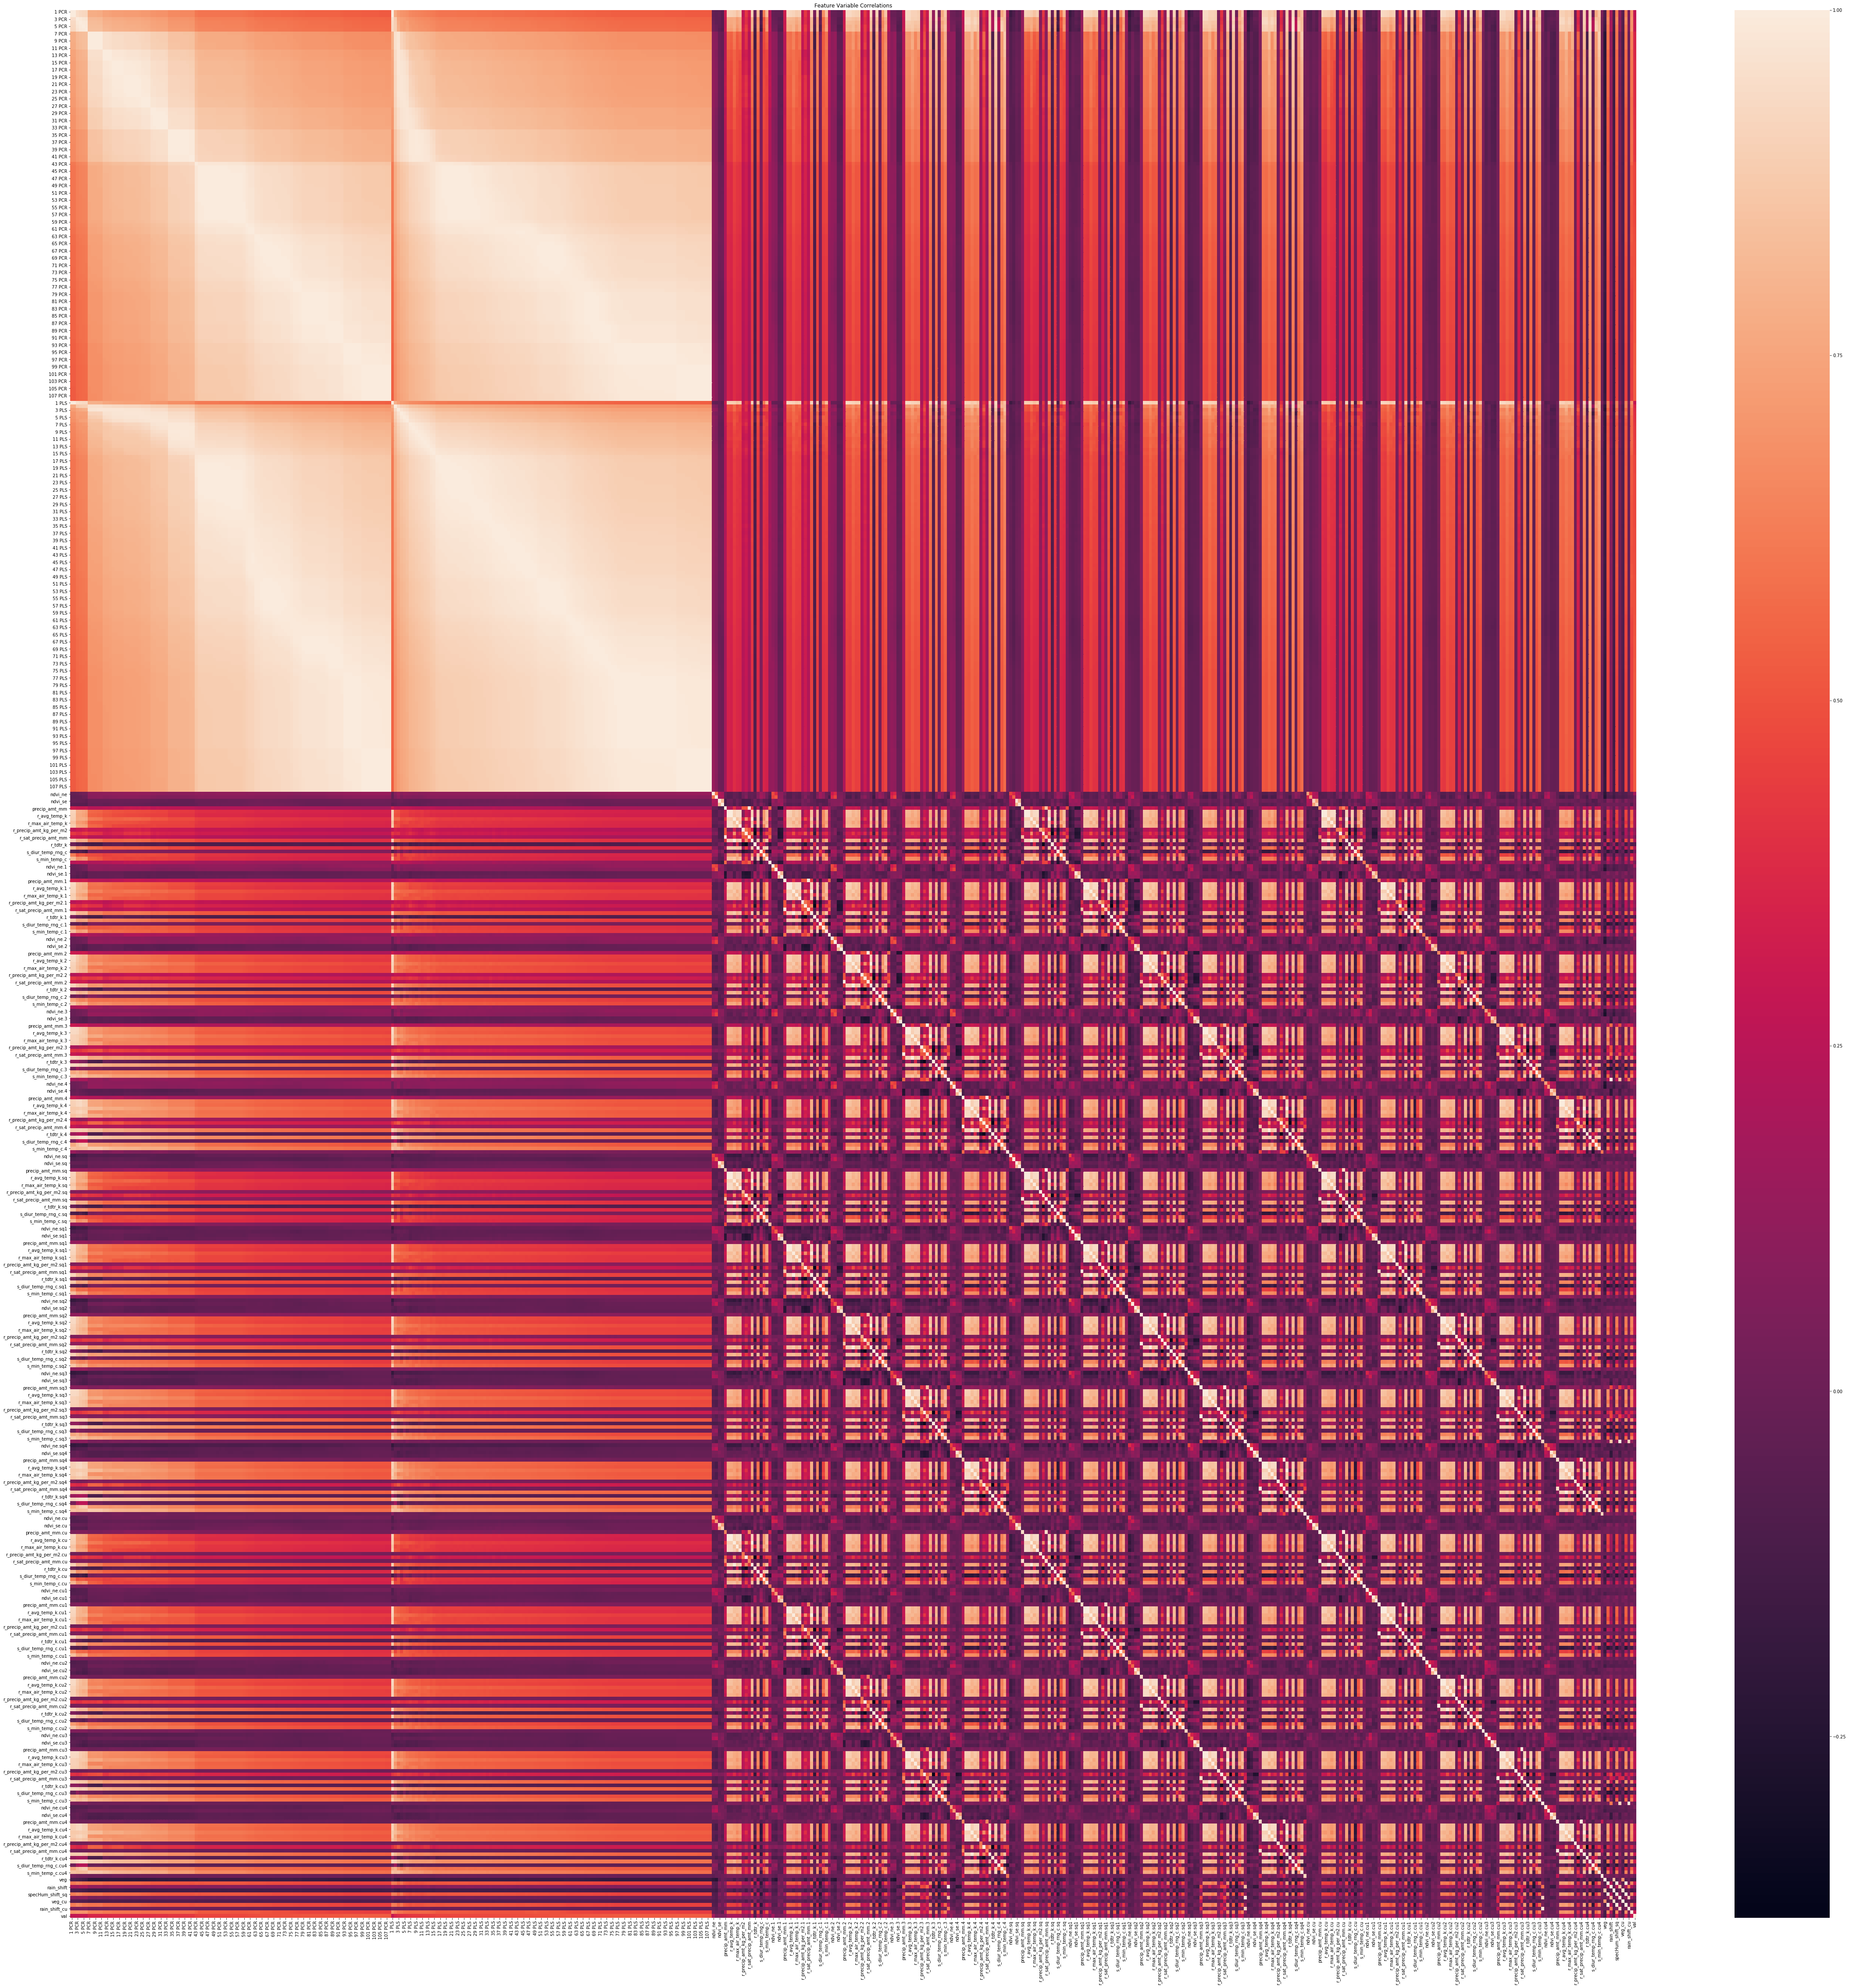

In [297]:
# plot feature correlation
plt.figure()
plt.figure(figsize=(80,80))
feat_corr_heat = sns.heatmap(feat_correlations)
plt.title('Feature Variable Correlations')
plt.show()

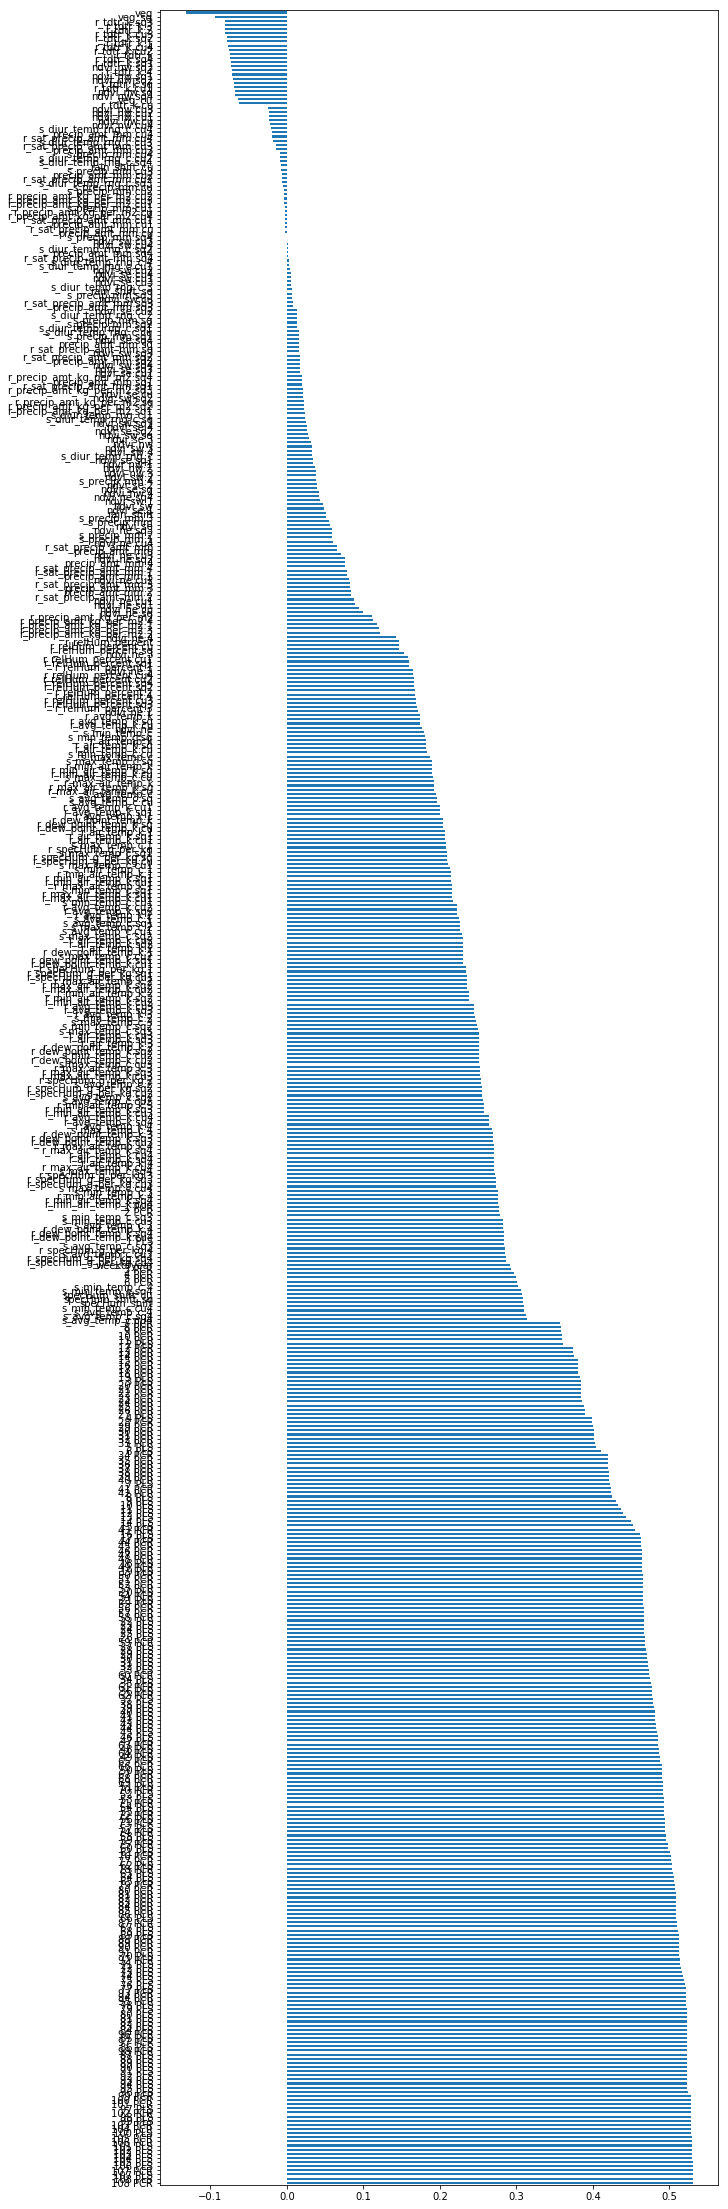

In [298]:
# Features
plt.figure()
plt.figure(figsize=(10,40))
(feat_correlations
     .val
     .drop('val') # don't compare with myself
#     .drop(regex='PCR')
     .sort_values(ascending=False)
     .plot
     .barh())
plt.show()
#plt.savefig('/Users/turk_la/Documents/SSAM/Data/UF6data/correlations_enrichment.png')

In [299]:
feat_correlations['2 PCR'].head()
#print([i for i in feat_correlations])

1 PCR    0.999995
2 PCR    1.000000
3 PCR    0.948428
4 PCR    0.935122
5 PCR    0.927016
Name: 2 PCR, dtype: float64

In [307]:
subset_features_PCR = [i for i in feat_correlations_PCR if (feat_correlations[i].val) > 0.53]
subset_features_PLS = [i for i in feat_correlations_PLS if (feat_correlations[i].val) > 0.53]
subset_features_nonP = [i for i in feat_correlations_nonP if (feat_correlations[i].val) > 0.25]
subset_features_nonP2 = [i for i in feat_correlations_nonP if (feat_correlations[i].val) < -0.1]
#subset_features = [i for i in feat_correlations if (feat_correlations[i].val) > 0.35 & feat_correlations[i] == "^PCR"]
#subset_features = [i for i in feat_correlations.filter(regex="[^PCR]")  if (feat_correlations[i].val) > 0.02]
#subset_features.append(subset_features_PCR)
subset_features = subset_features_PCR + subset_features_PLS + subset_features_nonP + subset_features_nonP2
subset_features.remove('val')
subset_features.remove('val')
subset_features.remove('val')
print(len(subset_features))

71


In [308]:
print(subset_features)

['107 PCR', '108 PCR', '104 PLS', '105 PLS', '106 PLS', '107 PLS', '108 PLS', 'r_dew_point_temp_k.2', 'r_specHum_g_per_kg.2', 's_avg_temp_c.2', 'r_air_temp_k.3', 'r_dew_point_temp_k.3', 'r_max_air_temp_k.3', 'r_min_air_temp_k.3', 'r_specHum_g_per_kg.3', 's_avg_temp_c.3', 's_min_temp_c.3', 'r_air_temp_k.4', 'r_avg_temp_k.4', 'r_dew_point_temp_k.4', 'r_max_air_temp_k.4', 'r_min_air_temp_k.4', 'r_specHum_g_per_kg.4', 's_avg_temp_c.4', 's_max_temp_c.4', 's_min_temp_c.4', 'r_dew_point_temp_k.sq2', 'r_specHum_g_per_kg.sq2', 's_avg_temp_c.sq2', 'r_air_temp_k.sq3', 'r_dew_point_temp_k.sq3', 'r_max_air_temp_k.sq3', 'r_min_air_temp_k.sq3', 'r_specHum_g_per_kg.sq3', 's_avg_temp_c.sq3', 's_min_temp_c.sq3', 'r_air_temp_k.sq4', 'r_avg_temp_k.sq4', 'r_dew_point_temp_k.sq4', 'r_max_air_temp_k.sq4', 'r_min_air_temp_k.sq4', 'r_specHum_g_per_kg.sq4', 's_avg_temp_c.sq4', 's_max_temp_c.sq4', 's_min_temp_c.sq4', 'r_dew_point_temp_k.cu2', 'r_specHum_g_per_kg.cu2', 's_avg_temp_c.cu2', 's_min_temp_c.cu2', 'r_a

In [18]:
subset_features = [
                     "r_dew_point_temp_k.4", "r_specHum_g_per_kg.4", "s_precip_mm.4", 
                     "veg", "specHum_shift", "weekofyear"]

In [19]:
PCRpls_list = ['1 PCR','4 PCR','7 PCR','36 PCR','1 PLS','3 PLS','6 PLS','36 PLS']
subset_features += PCRpls_list
print(subset_features)

['r_dew_point_temp_k.4', 'r_specHum_g_per_kg.4', 's_precip_mm.4', 'veg', 'specHum_shift', 'weekofyear', '1 PCR', '4 PCR', '7 PCR', '36 PCR', '1 PLS', '3 PLS', '6 PLS', '36 PLS']


## Next we will perform cross validations to select hyperparameters for four different models: 
### full channel, subset channel, full feature, subset feature

In [246]:
#perform cross-validation to find best value of alpha

def alpha_CV(columns, X_train, X_test, y_train, y_test):
    alphas = np.logspace(-5, 3, 9)
    names = []
    for i in alphas:
        names.append('alpha ' + str(i))

    classifiers = []
    for i in alphas:
        classifiers.append(MLPRegressor(solver='adam', activation='tanh', alpha=i, random_state=1))

    x = alphas
    y = []

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        y.append(score)
        #print(clf, score)
    
    #plt.plot(x, y)
    #plt.show()
    return(zip(alphas, y))

In [247]:
#perform cross-validation to find best solver

def solver_CV(columns, X_train, X_test, y_train, y_test):
    solvers = ['lbfgs','sgd','adam']
    names = []
    for i in solvers:
        names.append('solver= ' + str(i))

    classifiers = []
    for i in solvers:
        classifiers.append(MLPRegressor(solver=i, activation='tanh', learning_rate='adaptive', alpha=0.1, random_state=1))
        
    x = [1,2,3]
    y = []

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        y.append(score)
        #print(clf, score)

    #plt.plot(x, y)
    #plt.show()
    return(zip(solvers, y))

In [248]:
#perform some cross-validation to find best activation function
def activation_CV(columns, X_train, X_test, y_train, y_test):
    activators = ['identity', 'logistic', 'tanh', 'relu']
    names = []
    for i in activators:
        names.append('activator= ' + str(i))

    classifiers = []
    for i in activators:
        classifiers.append(MLPRegressor(solver='adam', activation=i, alpha=0.1, random_state=1))

    x = [1,2,3,4]
    y = []

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        y.append(score)
        #print(clf, score)

    #plt.plot(x, y)
    #plt.show()
    return(zip(activators, y))

In [249]:
# preprocess dataset, split into training and test part
def data_split(data, keys, columns):
    X_train, X_test, y_train, y_test = train_test_split(data, keys, 
                                                            test_size=0.33, random_state=42)

    cst = ColumnSelectTransformer(columns)
    X_train1 = cst.transform(X_train)
    X_train_std = StandardScaler().fit_transform(X_train1)
    X_test1 = cst.transform(X_test)
    X_test_std = StandardScaler().fit_transform(X_test1)

    return(columns, X_train_std, X_test_std, y_train, y_test)
    


In [250]:
def data_transform(dataTRN, dataTEST, columns):
    # just transform the already split data

    cst = ColumnSelectTransformer(columns)
    X_train1 = cst.transform(dataTRN)
    X_train_std = StandardScaler().fit_transform(X_train1)
    X_test1 = cst.transform(dataTEST)
    X_test_std = StandardScaler().fit_transform(X_test1)

    return(columns, X_train_std, X_test_std)

In [187]:
#col_fullfeat, X_train_fullfeat, X_test_fullfeat, y_train_fullfeat, y_test_fullfeat = data_split(featdata, featkeys, features)
#col_subfeat, X_train_subfeat, X_test_subfeat, y_train_subfeat, y_test_subfeat = data_split(featdata, featkeys, subset_features)

In [311]:
featkeysTES = 0
print(featdata.shape)
print(featkeys.shape)
print(featdataTRN.shape)
print(featkeysTRN.shape)
print(featdataTES.shape)
print(featkeysTES.shape)
print(len(features))

(936, 526)
(936, 1)
(936, 526)
(936, 1)
(260, 526)


AttributeError: 'int' object has no attribute 'shape'

In [312]:
col_fullfeat, X_train_fullfeat, X_test_fullfeat = data_transform(featdataTRN, featdataTES, features)
y_train_fullfeat, y_test_fullfeat = featkeys, featkeysTES
col_subfeat, X_train_subfeat, X_test_subfeat = data_transform(featdataTRN, featdataTES, subset_features)
y_train_subfeat, y_test_subfeat = featkeysTRN, featkeysTES

In [314]:
featkeysTES

0

In [253]:
alpha_full_feat = alpha_CV(col_fullfeat, X_train_fullfeat, X_test_fullfeat, y_train_fullfeat, y_test_fullfeat)
print(list(alpha_full_feat))

solver_full_feat = solver_CV(col_fullfeat, X_train_fullfeat, X_test_fullfeat, y_train_fullfeat, y_test_fullfeat)
print(list(solver_full_feat))

activation_full_feat = activation_CV(col_fullfeat, X_train_fullfeat, X_test_fullfeat, y_train_fullfeat, y_test_fullfeat)
print(list(activation_full_feat))

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[(1.0000000000000001e-05, 0.19338538026226992), (0.0001, 0.193385565030749), (0.001, 0.1933874123233964), (0.01, 0.19340584578911524), (0.10000000000000001, 0.19358692110701592), (1.0, 0.19500853649197702), (10.0, 0.2057197527199367), (100.0, 0.24189684899387251), (1000.0, 0.093190188891393744)]
[('lbfgs', 0.099279759297504988), ('sgd', 0.22062668318720347), ('adam', 0.19358692110701592)]
[('identity', 0.12996308673706447), ('logistic', 0.22156201301661779), ('tanh', 0.19358692110701592), ('relu', 0.30554624346255965)]


In [254]:
alpha_sub_feat = alpha_CV(col_subfeat, X_train_subfeat, X_test_subfeat, y_train_subfeat, y_test_subfeat)
print(list(alpha_sub_feat))

solver_sub_feat = solver_CV(col_subfeat, X_train_subfeat, X_test_subfeat, y_train_subfeat, y_test_subfeat)
print(list(solver_sub_feat))

activation_sub_feat = activation_CV(col_subfeat, X_train_subfeat, X_test_subfeat, y_train_subfeat, y_test_subfeat)
print(list(activation_sub_feat))

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[(1.0000000000000001e-05, 0.22604382726141603), (0.0001, 0.2260438219293982), (0.001, 0.22604376860848974), (0.01, 0.22604323530601356), (0.10000000000000001, 0.22603789473796651), (1.0, 0.22598311550956862), (10.0, 0.22528002224855237), (100.0, 0.21774243992071651), (1000.0, 0.17081470370944174)]
[('lbfgs', -0.23340958537004577), ('sgd', 0.29051287814301008), ('adam', 0.22603789473796651)]
[('identity', 0.17323247588150203), ('logistic', 0.20727072308986494), ('tanh', 0.22603789473796651), ('relu', 0.28399748253495904)]


### Finallly we will train four different models on the full data set

In [315]:
# just read in data from files and over-write
featkeysTRN = pd.read_csv('/home/jack/projects/dengue/data/sj_train100per_labels.csv')

featdataTRN = pd.read_csv('/home/jack/projects/dengue/data/sj_train100per.csv')
featdataTES = pd.read_csv('/home/jack/projects/dengue/data/sj_testTrue.csv')

In [317]:
print(featdata.shape)
print(featkeys.shape)
print(featdataTRN.shape)
print(featkeysTRN.shape)
print(featdataTES.shape)

print(len(features))

(936, 526)
(936, 1)
(936, 526)
(936, 1)
(260, 526)
526


In [318]:
params =  {'rfr__n_estimators':800, 'rfr__max_features': 65}
RF_subset_feat.set_params(**params)

RF_subset_feat.fit(featdataTRN,featkeysTRN)
y_pred5 = RF_subset_feat.predict(featdataTES)

/usr/local/lib/python3.5/dist-packages/sklearn/pipeline.py:259: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [319]:
NN_subset_feat.fit(featdataTRN,featkeysTRN)
y_pred4 = NN_subset_feat.predict(featdataTES)

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [320]:
print(len(y_pred5))
len(y_pred4)

260


260

In [276]:
# Create a Pipeline which you can use to train and predict
# Step 1: take the data (training or testing) and select only the columns of interest
# Step 2: transform all of the features to Standard Variables
# Step 3: feed the data into a Multi-Layer Perceptron 

NN_full_feat = Pipeline([
    ('cst', ColumnSelectTransformer(features)),
    ('sdt', StandardScaler()),
    ('mlp', MLPRegressor(solver='adam', activation='relu', alpha=100.0)) #, alpha=0.1))
    ])

NN_subset_feat = Pipeline([
    ('cst', ColumnSelectTransformer(subset_features)),
    ('sdt', StandardScaler()),
    ('mlp', MLPRegressor(solver='adam', activation='relu', alpha=0.1))
    ])

RF_full_feat = Pipeline([
    ('cst', ColumnSelectTransformer(features)),
    ('sdt', StandardScaler()),
    ('rfr', RandomForestRegressor(n_estimators=800))
    ])

RF_subset_feat = Pipeline([
    ('cst', ColumnSelectTransformer(subset_features)),
    ('sdt', StandardScaler()),
    ('rfr', RandomForestRegressor(n_estimators=800))
    ])

In [277]:
# split the data into training and testing
#X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(featdata, featkeys, test_size=0.33, random_state=42)

In [278]:
print(len(featkeysTES))
len(subset_features)

279


72

In [279]:
#NN_full_feat.set_params(alpha = 100)
NN_full_feat.fit(featdataTRN,featkeysTRN)
y_pred3 = NN_full_feat.predict(featdataTES)


y_test_feat = featkeysTES
# Save the trained model
#joblib.dump(NN_full_feat, '/Users/turk_la/Documents/SSAM/Data/UF6data/NN_full_features.pkl')

y_test_feat['pred'] = y_pred3
y_test_feat['dif'] = abs(y_test_feat['x'] - y_test_feat['pred'])
y_test_feat['dif'].sum()/len(featkeysTES)

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


24.682015815722661

In [280]:
NN_subset_feat.fit(featdataTRN,featkeysTRN)
y_pred4 = NN_subset_feat.predict(featdataTES)

y_test_feat = featkeysTES

y_test_feat['pred4'] = y_pred4
y_test_feat['dif_sub'] = abs(y_test_feat['x'] - y_test_feat['pred4'])
y_test_feat['dif_sub'].sum()/len(featkeysTES)

# Save the trained model
#joblib.dump(NN_subset_feat, '/Users/turk_la/Documents/SSAM/Data/UF6data/NN_sub_features.pkl')


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


21.94134468358865

In [281]:
params =  {'rfr__n_estimators':800, 'rfr__max_features': 65}
RF_subset_feat.set_params(**params)

RF_subset_feat.fit(featdataTRN,featkeysTRN)
y_pred5 = RF_subset_feat.predict(featdataTES)

y_test_feat = featkeysTES

y_test_feat['pred5'] = y_pred5
y_test_feat['dif_sub_rf'] = abs(y_test_feat['x'] - y_test_feat['pred5'])
y_test_feat['dif_sub_rf'].sum()/len(featkeysTES)

/usr/local/lib/python3.5/dist-packages/sklearn/pipeline.py:259: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


18.224481033452808

In [202]:
RF_full_feat.get_params()

{'cst': ColumnSelectTransformer(col_names=['1 PCR', '2 PCR', '3 PCR', '4 PCR', '5 PCR', '6 PCR', '7 PCR', '8 PCR', '9 PCR', '10 PCR', '11 PCR', '12 PCR', '13 PCR', '14 PCR', '15 PCR', '16 PCR', '17 PCR', '18 PCR', '19 PCR', '20 PCR', '21 PCR', '22 PCR', '23 PCR', '24 PCR', '25 PCR', '26 PCR', '27 PCR', '28 PCR', '29 PCR', '30 PCR'...Hum_shift_sq', 'rain_shift_sq', 'veg_cu', 'specHum_shift_cu', 'rain_shift_cu', 'year', 'weekofyear']),
 'cst__col_names': ['1 PCR',
  '2 PCR',
  '3 PCR',
  '4 PCR',
  '5 PCR',
  '6 PCR',
  '7 PCR',
  '8 PCR',
  '9 PCR',
  '10 PCR',
  '11 PCR',
  '12 PCR',
  '13 PCR',
  '14 PCR',
  '15 PCR',
  '16 PCR',
  '17 PCR',
  '18 PCR',
  '19 PCR',
  '20 PCR',
  '21 PCR',
  '22 PCR',
  '23 PCR',
  '24 PCR',
  '25 PCR',
  '26 PCR',
  '27 PCR',
  '28 PCR',
  '29 PCR',
  '30 PCR',
  '31 PCR',
  '32 PCR',
  '33 PCR',
  '34 PCR',
  '35 PCR',
  '36 PCR',
  '37 PCR',
  '38 PCR',
  '39 PCR',
  '40 PCR',
  '41 PCR',
  '42 PCR',
  '43 PCR',
  '44 PCR',
  '45 PCR',
  '46 PCR',
 

In [260]:
#params = ['n_estimators': 800, 'max_features': 165
params =  {'rfr__n_estimators':1200, 'rfr__max_features': 365}
RF_full_feat.set_params(**params)
RF_full_feat.fit(featdataTRN,featkeysTRN)
y_pred6 = RF_full_feat.predict(featdataTES)

y_test_feat = featkeysTES

y_test_feat['pred6'] = y_pred6
y_test_feat['dif_sub_rf'] = abs(y_test_feat['x'] - y_test_feat['pred6'])
y_test_feat['dif_sub_rf'].sum()/len(featkeysTES)

/usr/local/lib/python3.5/dist-packages/sklearn/pipeline.py:259: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


19.416039426523302

In [204]:
y_pred3
print(y_pred4.shape)
w = sum(y_pred4)
print(w/260)

(279,)
36.4968004883


In [322]:
## making  submission
#submission = pd.read_csv('/home/jack/projects/dengue/data/submission_format.csv')

# submission 13 for Iq
submission = pd.read_csv('/home/jack/projects/dengue/results/predictions13_EM.csv')

count = 0
for i in y_pred4:
    if i < 0.0:
        print(i)
        submission.loc[count,'total_cases'] = 0.0
    else:
        submission.loc[count,'total_cases'] = i
    count += 1

submission.to_csv('/home/jack/projects/dengue/results/predictions29_EM.csv',index='FALSE')
    
#submission.total_cases = np.concatenate([y_pred6])
    
#submission.head()
#submission.tail()
#submission.shape
#submission.loc[411, 'weekofyear']

-1.13606606099
-0.228565152467
-2.24558859414
-0.105710582894
-3.66883857408
-9.52665013553
-4.38793222201
-3.60593821475
-3.19105211438
-0.186407440519
-1.44281610255
-0.937245154553


In [225]:
y_pred5

array([  14.81875   ,    9.98916667,    5.88125   ,    7.49770833,
         15.43958333,   16.22916667,   34.46145833,  241.76791667,
         31.5475    ,   13.60791667,   26.73833333,   24.35416667,
         22.78458333,   51.72791667,   39.59208333,   59.15291667,
         22.60125   ,   27.75333333,   28.46666667,   72.78541667,
         64.96375   ,  214.58916667,  164.05875   ,   85.61291667,
         84.8675    ,   94.32208333,   84.35333333,   70.75708333,
         63.89333333,   41.15583333,   70.1625    ,   64.30291667,
         57.5575    ,   30.39375   ,   27.73083333,   14.27875   ,
         14.09291667,   13.20791667,   14.04666667,    9.92333333,
          9.33291667,   11.96875   ,    9.10041667,    8.03541667,
          6.73458333,    8.22333333,    6.2075    ,    9.05833333,
          5.41791667,    3.56833333,    3.46416667,    3.0225    ,
          3.50166667,    4.12208333,    3.55958333,    6.02541667,
          5.66416667,    5.38375   ,    8.84666667,    9.1925 

In [94]:
subset_features

['43 PCR',
 '44 PCR',
 '45 PCR',
 '46 PCR',
 '47 PCR',
 '48 PCR',
 '49 PCR',
 '50 PCR',
 '51 PCR',
 '52 PCR',
 '53 PCR',
 '54 PCR',
 '55 PCR',
 '56 PCR',
 '57 PCR',
 '58 PCR',
 '59 PCR',
 '60 PCR',
 '61 PCR',
 '62 PCR',
 '63 PCR',
 '64 PCR',
 '65 PCR',
 '66 PCR',
 '67 PCR',
 '68 PCR',
 '69 PCR',
 '70 PCR',
 '71 PCR',
 '72 PCR',
 '73 PCR',
 '74 PCR',
 '75 PCR',
 '76 PCR',
 '77 PCR',
 '78 PCR',
 '79 PCR',
 '80 PCR',
 '81 PCR',
 '82 PCR',
 '83 PCR',
 '84 PCR',
 '85 PCR',
 '86 PCR',
 '87 PCR',
 '88 PCR',
 '89 PCR',
 '90 PCR',
 '91 PCR',
 '92 PCR',
 '93 PCR',
 '94 PCR',
 '95 PCR',
 '96 PCR',
 '97 PCR',
 '98 PCR',
 '99 PCR',
 '100 PCR',
 '101 PCR',
 '102 PCR',
 '103 PCR',
 '104 PCR',
 '105 PCR',
 '106 PCR',
 '107 PCR',
 '108 PCR',
 '14 PLS',
 '15 PLS',
 '16 PLS',
 '17 PLS',
 '18 PLS',
 '19 PLS',
 '20 PLS',
 '21 PLS',
 '22 PLS',
 '23 PLS',
 '24 PLS',
 '25 PLS',
 '26 PLS',
 '27 PLS',
 '28 PLS',
 '29 PLS',
 '30 PLS',
 '31 PLS',
 '32 PLS',
 '33 PLS',
 '34 PLS',
 '35 PLS',
 '36 PLS',
 '37 PLS',
 

In [95]:
y_pred4[:10]

array([ 46.5373877 ,  55.38938291,  71.67194722,  46.94775503,
        41.68927422,  21.9409246 ,  33.4955104 ,  36.34159778,
        13.24295493,  23.27460081])

In [96]:
print(len(col_subfeat), X_train_subfeat.shape, X_test_subfeat.shape, y_train_subfeat.shape, y_test_subfeat.shape)
y_test_subfeat.head()

205 (657, 205) (279, 205) (657, 1) (279, 8)


,x,pred,dif,pred4,dif_sub,pred5,dif_sub_rf,pred6
0,3.666667,23.402508,19.735841,46.537388,42.870721,34.052292,20.640625,24.307292
1,6.333333,47.548842,41.215509,55.389383,49.056050,34.092083,23.408333,29.741667
2,7.000000,53.093077,46.093077,71.671947,64.671947,38.440417,29.406667,36.406667
3,5.333333,63.291865,57.958532,46.947755,41.614422,55.821667,52.364167,57.697500
4,55.000000,39.590173,15.409827,41.689274,13.310726,49.715833,11.484583,66.484583


In [267]:
forest_sub_feat = forest_CV(col_subfeat, X_train_subfeat, X_test_subfeat, y_train_subfeat, y_test_subfeat['x'])

n_est=800 max_feat=56 min_samp_split=2 min_samp_leaf=1 0.513144347654
n_est=800 max_feat=61 min_samp_split=2 min_samp_leaf=1 0.518268922686
n_est=800 max_feat=66 min_samp_split=2 min_samp_leaf=1 0.518992778444


In [205]:
forest_fullfeat = forest_CV(col_fullfeat, X_train_fullfeat, X_test_fullfeat, y_train_fullfeat, y_test_fullfeat['x'])

n_est=600 max_feat=31 min_samp_split=2 min_samp_leaf=1 0.390312862084
n_est=600 max_feat=61 min_samp_split=2 min_samp_leaf=1 0.383524244739
n_est=600 max_feat=91 min_samp_split=2 min_samp_leaf=1 0.360778385893
n_est=600 max_feat=121 min_samp_split=2 min_samp_leaf=1 0.356969873928
n_est=600 max_feat=151 min_samp_split=2 min_samp_leaf=1 0.358104002613
n_est=600 max_feat=181 min_samp_split=2 min_samp_leaf=1 0.351907498607
n_est=600 max_feat=230 min_samp_split=2 min_samp_leaf=1 0.343049785058
n_est=600 max_feat=400 min_samp_split=2 min_samp_leaf=1 0.339314008549
n_est=800 max_feat=31 min_samp_split=2 min_samp_leaf=1 0.387416508035
n_est=800 max_feat=61 min_samp_split=2 min_samp_leaf=1 0.382510536811
n_est=800 max_feat=91 min_samp_split=2 min_samp_leaf=1 0.364235914643
n_est=800 max_feat=121 min_samp_split=2 min_samp_leaf=1 0.375228906698
n_est=800 max_feat=151 min_samp_split=2 min_samp_leaf=1 0.394005926925
n_est=800 max_feat=181 min_samp_split=2 min_samp_leaf=1 0.340092126324
n_est=800 ma

KeyboardInterrupt: 

In [ ]:
## Experimenting with implementing a time series aspect

X_tr, X_ts, y_tr, y_ts = featdata[:800], featdata[800:], featkeys[:800], featkeys[800:]

RF_full_feat.fit(X_tr,y_tr)

preds = []

new_val= y_tr['x'][799]

for i in range(936-800):

    #print(new_val)

    X_ts.loc[i+800,'prior_val'] = float(new_val)

    #print(X_ts.loc[i+800,'prior_val'])

    datum = X_ts[i:i+1]

    #print(datum)    

    new_val = RF_full_feat.predict(datum)

    preds.append(float(new_val))

    

y_ts['pred'] = preds

y_ts['dif'] = abs(y_ts['x'] - y_ts['pred'])

y_ts['dif'].sum()/len(y_ts)